In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import contextily as cx
import datetime as dt
import json
import time

from functions_file import *
print(testfunction(4))

16


### Outline
1. Import data and add basic information
    1. Import data
    1. Define area & Coarse filtering
    1. Add information
    1. Fine filtering
2. Clean data
2. Look at data
3. Look at diff. modes
6. Check distance and speed values

### 1. Import (cleaned, per polygon, without parking removed) data and add basic information

In [2]:
polygon_name = 'polygon_r0'
polygons = pd.read_csv('../data/polygons11.csv') #polygons11
POLYGON = get_polygon(polygon_name,polygons)
file_name = '../output/data_clean_with_parked/prepared_data_%s.pkl'%(polygon_name) #change again
file_type = 'pickle'
waypoints_w_dist_mode = import_clean_data(file_name,file_type,polygon_name)

### 2. Clean Data

In [3]:
'''
# remove parking vehicles ##think twice, if we really want this
# definition: parked vehicles = travelled less than 1/10 of the segments length during the whole experiment
group_df = pd.DataFrame()
group_df[['unique_id','d1']] = waypoints_w_dist_mode.groupby('unique_id')['trv_dist'].max().reset_index()[['unique_id','trv_dist']]
group_df['d0'] = waypoints_w_dist_mode.groupby('unique_id')['trv_dist'].min().reset_index()['trv_dist']
group_df['ddiff'] = group_df.d1-group_df.d0
display(group_df.head())
cutoff_distance = POLYGON['length']*1000 / 4 #4 or 10
remove = group_df[group_df.ddiff<cutoff_distance].unique_id.values
#waypoints_w_dist_mode = waypoints_w_dist_mode[~waypoints_w_dist_mode.unique_id.isin(remove)]
print('%.1f%% of probes cover less than %s of the %s m'%(100*len(group_df[group_df.ddiff<cutoff_distance])/len(group_df),cutoff_distance,POLYGON['length']*1000))
parked = waypoints_w_dist_mode[waypoints_w_dist_mode.unique_id.isin(remove)]
max_time = pd.DataFrame()
max_time[['unique_id','max_time']] = parked.groupby('unique_id')['time'].max().reset_index()[['unique_id','time']]
max_time['min_time'] = parked.groupby('unique_id')['time'].min().reset_index()['time']
max_time['max_trv'] = parked.groupby('unique_id')['trv_dist'].max().reset_index()['trv_dist']
max_time['min_trv'] = parked.groupby('unique_id')['trv_dist'].min().reset_index()['trv_dist']
max_time['dist_trv'] = max_time['max_trv']-max_time['min_trv']
max_time['speed'] = max_time.dist_trv/(max_time.max_time-max_time.min_time)
plt.scatter(max_time.dist_trv,max_time.max_time-max_time.min_time)
max_time.speed.hist()

#max_dist = parked.groupby('unique_id')['trv_dist'].max()-parked.groupby('trv_dist')['time'].min()
#standstils = parked.groupby('unique_id')['type'].unique().value_counts()
#max_time.hist(bins=45)
'''

,unique_id,d1,d0,ddiff
0,1000858,176.571756,75.053930,101.517827
1,1000860,171.207626,68.342487,102.865139
2,1001021,132.179995,30.007051,102.172944
3,1001491,192.467794,89.538612,102.929181
4,1001506,192.366532,89.620327,102.746205


1.4% of probes cover less than 26.25 of the 105.0 m


In [10]:
'''
#Make line-shapefiles from the dataframe
gdf = parked
def make_lines(point_list):
    if len(point_list)==1:
        return None #Point(point_list)
    else:
        return LineString(point_list)
breakpoint()
line_gdf = gdf.sort_values(by=['time']).groupby(['unique_id'])['geometry'].apply(lambda x:make_lines(x.tolist()))
line_gdf = gpd.GeoDataFrame(line_gdf, geometry='geometry')
line_gdf.crs="EPSG:4326"
line_gdf.to_file('Shapefiles/parked.shp', driver='ESRI Shapefile')
'''

### 3. Look at Data

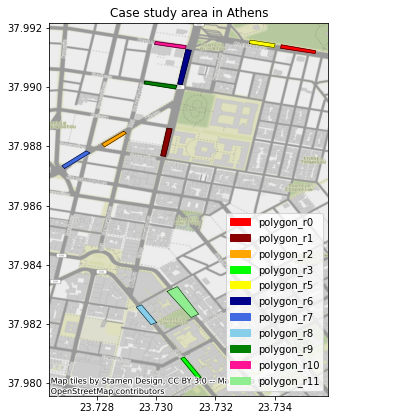

In [3]:
##################
# Plot all polygons with a contextily background map
##################
ax = waypoints_w_dist_mode.iloc[:100,:].plot(figsize=(5, 10), marker='o', color='gray', markersize=1,alpha=0.0)
colors = ['red','darkred','orange','lime','peru','yellow','darkblue',
          'royalblue','skyblue','green','deeppink','lightgreen','thistle','black']
polygons = pd.read_csv('../data/polygons11.csv')
for i,row in polygons.iterrows():
    if (row['name']=='polygon_r4'):# or (row['name']=='polygon_r11'):
        continue
    #i = min(i,10)
    p = get_polygon(row['name'],polygons)
    plt.fill(*p['coords'].exterior.xy,color=colors[i],label='%s'%row['name'])
    plt.plot(*p['coords'].exterior.xy,color='black',linewidth=0.5)

# current polygon
plt.legend(loc='lower right')
#cx.add_basemap(ax, crs=waypoints_w_dist_mode.crs, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, crs = waypoints_w_dist_mode.crs)
plt.title('Case study area in Athens')
#plt.savefig('LinksMap.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [4]:
'''
Vorgehen:
1. Filtere alle Bus - Medium - Heavy - Taxi Halte heraus
    Lösung: kleiner 1 kmh
2. Matche dort jedem Timestep die entsprechende 5 - Sek - Intervall - Geschwindigkeiten von v_all_MS zu
    Lösung: alle aussortiert, bei denen die mean speed der anderen Fahrzeuge (Car, Motorcycle) unter 10 liegt
3. Sortiere alle weg, bei denen v_all unter einer Schwelle liegt
    Lösung: Schwelle von 10 kmh, bei allem drunter würde es sowieso keinen impact haben
4. Gucke die Haltedauern an
5. Matche die Haltedauern auf die 30 Sekunden-Intervalle
6. Betrachte jeweils die v_all_MS vor, während und nach //v_all_but_bus
'''
print(waypoints_w_dist_mode['type'].unique())
waypoints_w_dist_mode.head(3)

['Car' 'Heavy Vehicle' 'Motorcycle' 'Taxi' 'Bus' 'Medium Vehicle']


,unique_id,type,exp_id,DOW,ST,ET,DOY,track_id,time,speed,trv_dist,timestamp,geometry
16035,1000858,Car,1,Wed,8.5,9.0,2018-10-24,858,148.24,32.1024,176.571756,2018-10-24 08:32:28.240,POINT (23.73537 37.99118)
16036,1000858,Car,1,Wed,8.5,9.0,2018-10-24,858,148.40,32.4627,175.149891,2018-10-24 08:32:28.400,POINT (23.73535 37.99118)
16037,1000858,Car,1,Wed,8.5,9.0,2018-10-24,858,148.56,32.7802,173.728042,2018-10-24 08:32:28.560,POINT (23.73533 37.99118)


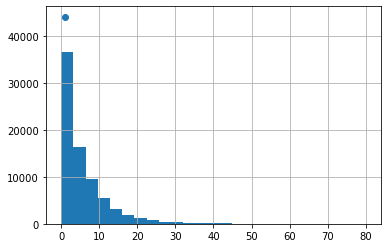

In [4]:
#for spe in range(1,15):
spe = 1
#filter for speed
data = waypoints_w_dist_mode[(waypoints_w_dist_mode.speed<spe)]
#calculate mean speed for each timestep, merge the mean speed to each datapoint
mspt = pd.DataFrame(waypoints_w_dist_mode[waypoints_w_dist_mode['type'].isin(['Car','Motorcycle'])]
                    .groupby('timestamp')['speed'].mean()).reset_index().rename(columns={'speed':'mean_speed'})
data = data.join(mspt.set_index('timestamp'), on=data['timestamp'])
#filter for vehicle types
spvec_stops = data[(data['type'].isin(['Bus','Taxi', 'Medium Vehicle', 'Heavy Vehicle']))]
plt.scatter(spe,len(spvec_stops.timestamp.unique()))
plt.show(spvec_stops.mean_speed.hist(bins=25))

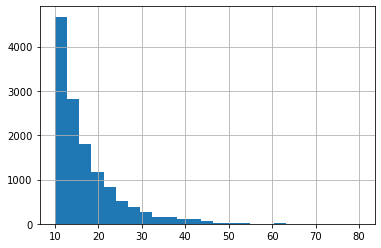

Anzahl an Fahrzeugen, die gehalten haben:  300


In [5]:
spvec_stops = spvec_stops[spvec_stops.mean_speed>10]
plt.show(spvec_stops.mean_speed.hist(bins=25))
print('Anzahl an Fahrzeugen, die gehalten haben: ', str(len(spvec_stops.unique_id.unique())))

C:\Users\ga59com\Anaconda3\envs\trb23wC\lib\site-packages\pandas\plotting\_matplotlib\core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


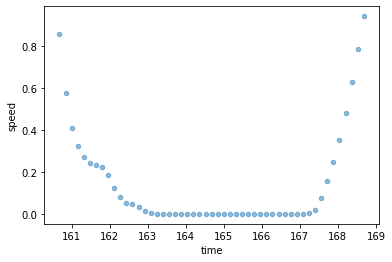

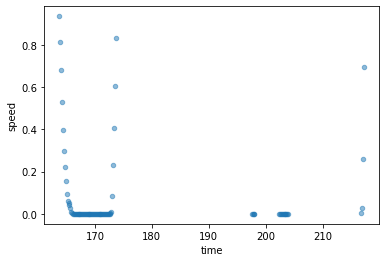

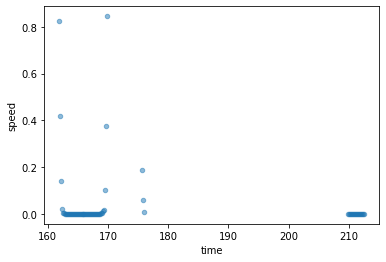

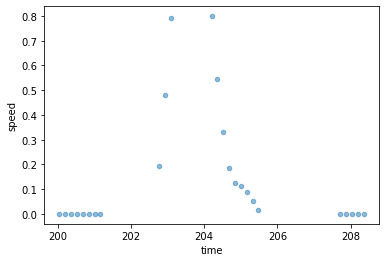

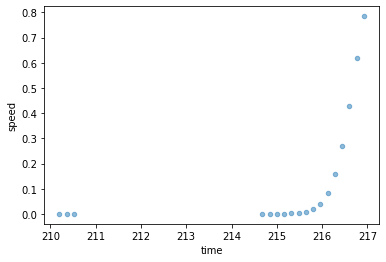

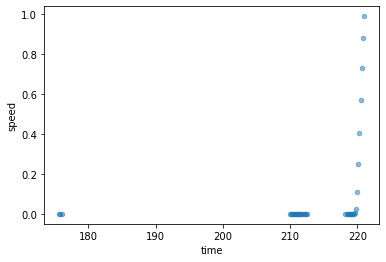

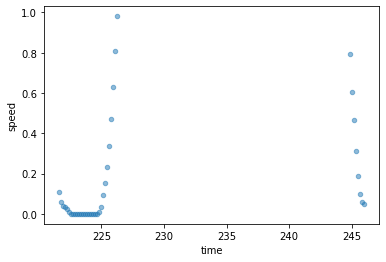

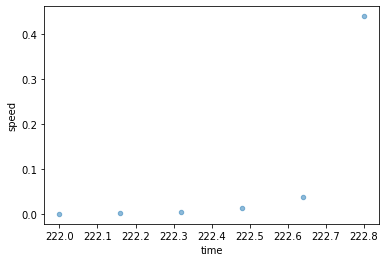

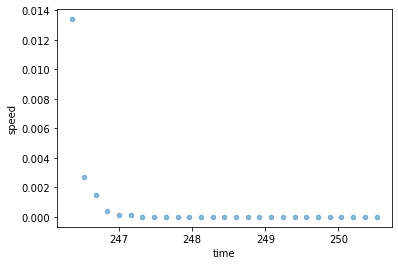

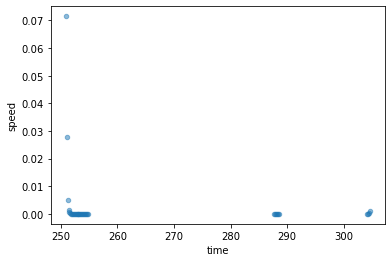

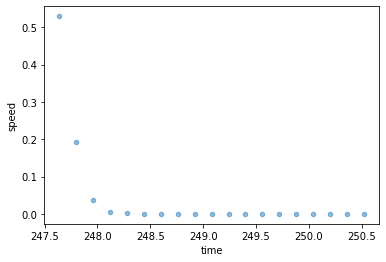

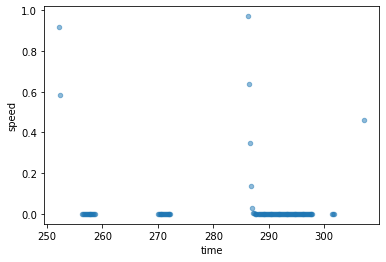

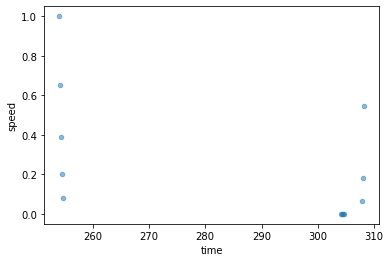

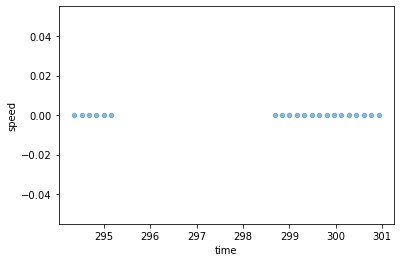

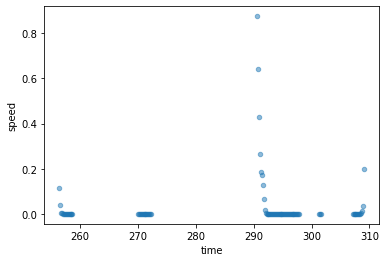

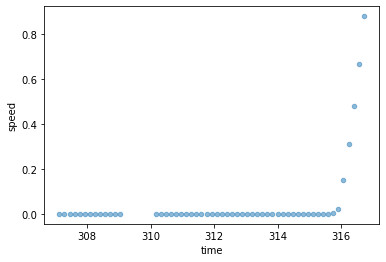

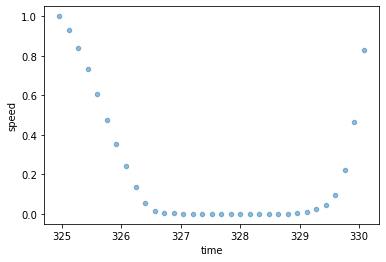

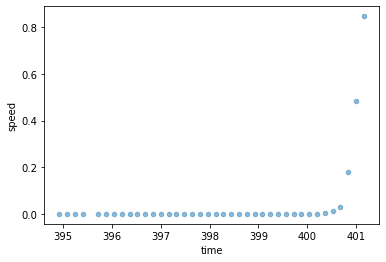

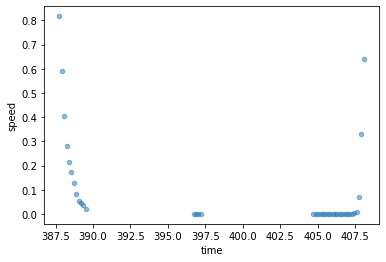

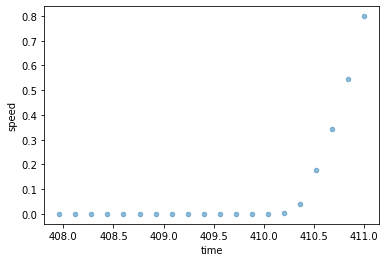

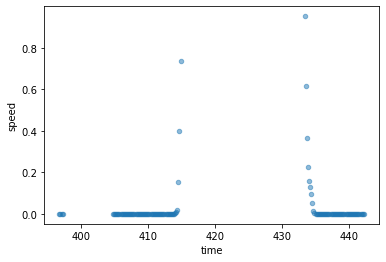

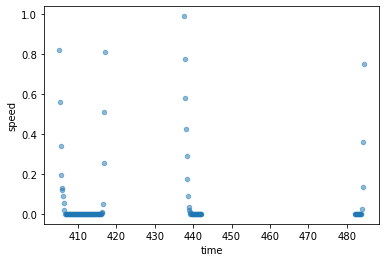

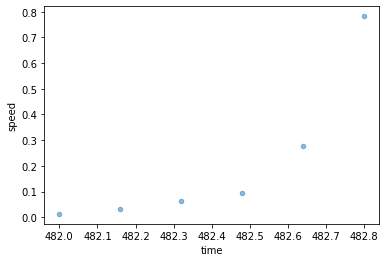

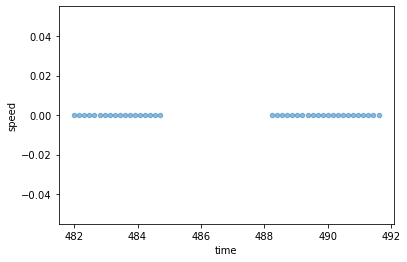

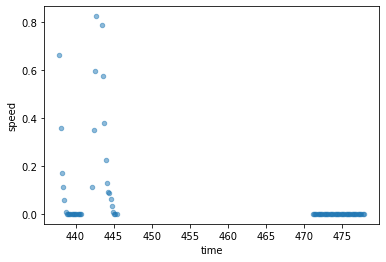

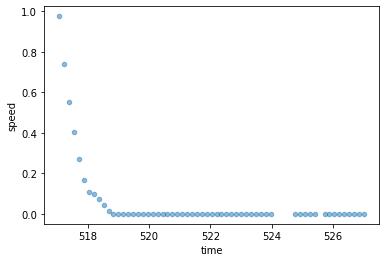

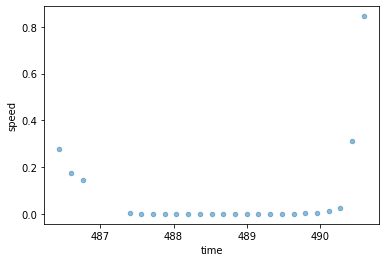

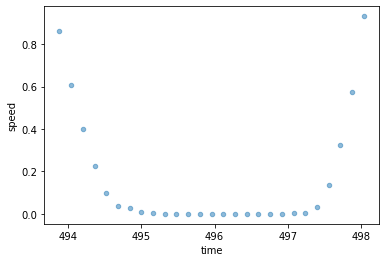

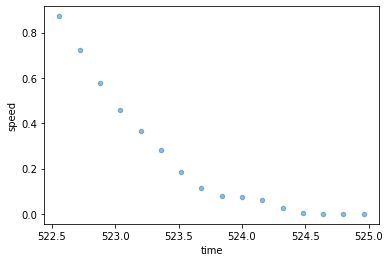

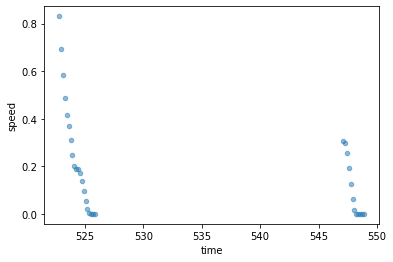

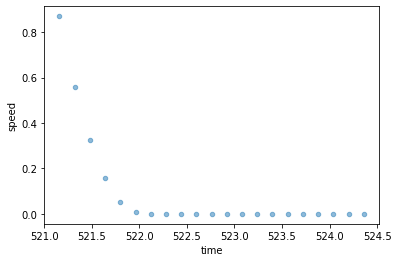

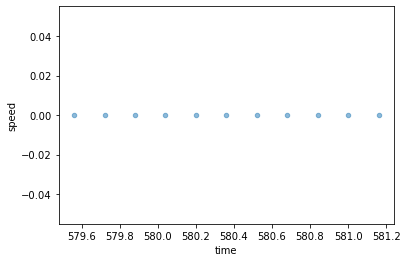

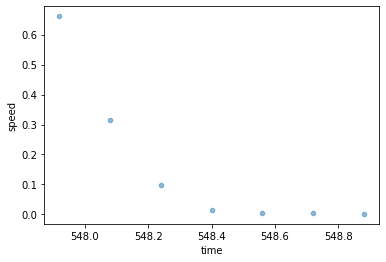

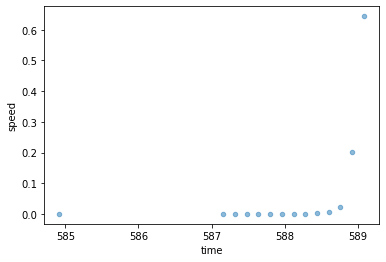

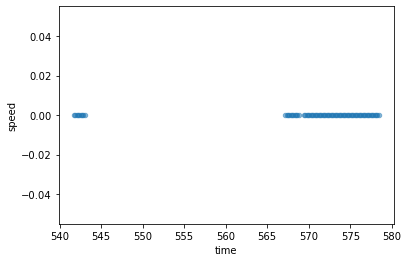

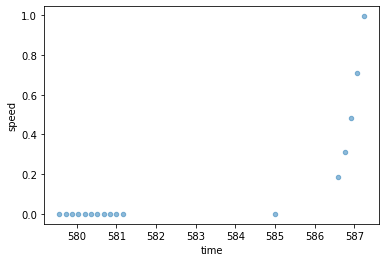

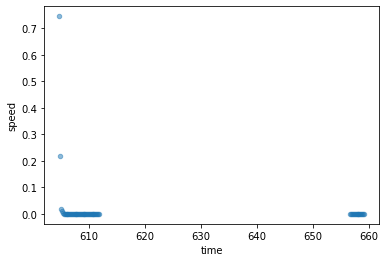

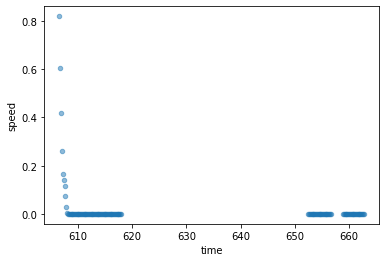

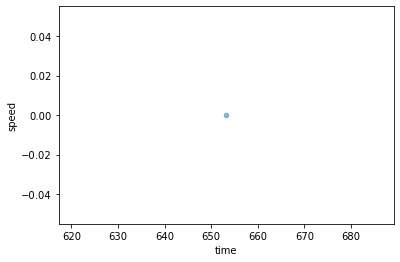

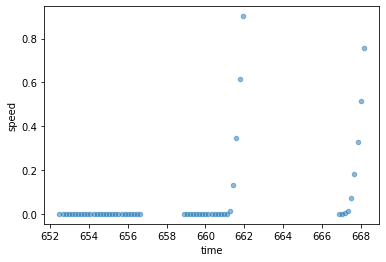

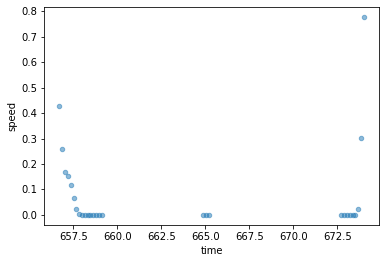

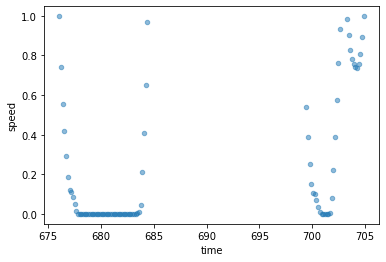

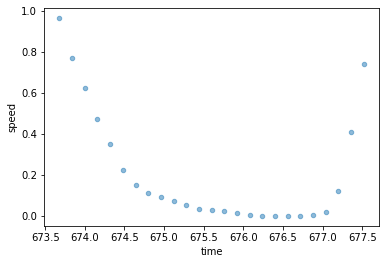

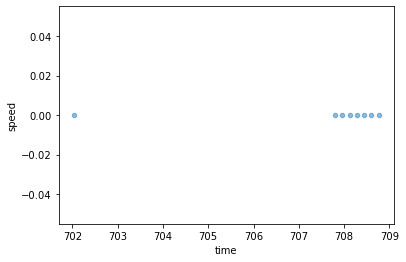

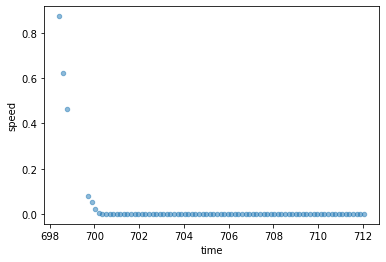

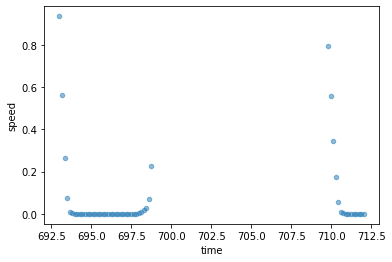

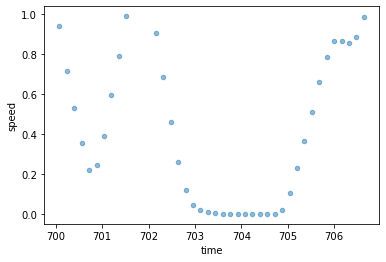

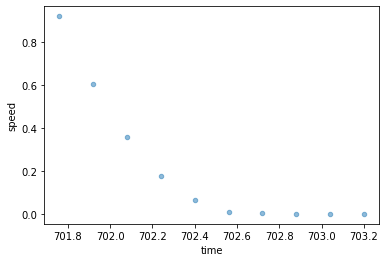

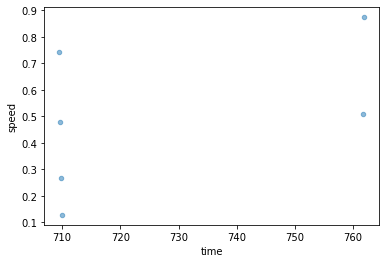

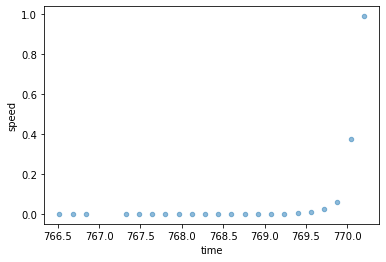

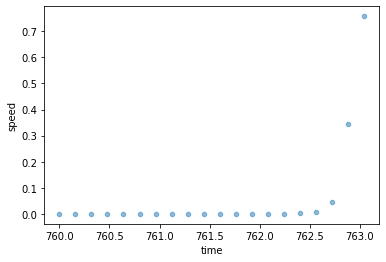

In [8]:
counter = 0
for unid in spvec_stops.unique_id.unique():
    temp = spvec_stops[spvec_stops.unique_id==unid]
    temp.plot.scatter(x="time", y="speed", alpha=0.5)
    counter+=1
    if counter>50:
        break

In [9]:
# Calculate speed differences for every time step, calculate timestamp difference for all ids_1 km/h
# Where the time diff is bigger than 1 second, a new stop id is reached

spvec_stops['speed_diff'] = spvec_stops.groupby('unique_id')['speed'].diff()
spvec_stops['time_diff'] = spvec_stops.groupby('unique_id')['timestamp'].diff()
spvec_stops['td_val'] = spvec_stops['time_diff'] > '2s'
unique_stop_id = 0
stop_ids = []
for i,row in spvec_stops.iterrows():
    if pd.isnull(row['time_diff']) or row['td_val']:
        unique_stop_id += 1
    stop_ids.append(unique_stop_id)
spvec_stops['stop_id'] = stop_ids
spvec_stops.tail()

,unique_id,type,exp_id,DOW,ST,ET,DOY,track_id,time,speed,trv_dist,timestamp,geometry,mean_speed,speed_diff,time_diff,td_val,stop_id
1538791,20009735,Medium Vehicle,20,Thu,10.0,10.5,2018-11-01,9735,849.24,0.1108,198.833824,2018-11-01 10:14:09.240,POINT (23.73430 37.99137),29.242700,-0.0145,0 days 00:00:00.160000,False,476
1538792,20009735,Medium Vehicle,20,Thu,10.0,10.5,2018-11-01,9735,849.40,0.0743,198.833824,2018-11-01 10:14:09.400,POINT (23.73430 37.99137),29.122700,-0.0365,0 days 00:00:00.160000,False,476
1538793,20009735,Medium Vehicle,20,Thu,10.0,10.5,2018-11-01,9735,849.56,0.0351,198.833824,2018-11-01 10:14:09.560,POINT (23.73430 37.99137),29.470033,-0.0392,0 days 00:00:00.160000,False,476
1538794,20009735,Medium Vehicle,20,Thu,10.0,10.5,2018-11-01,9735,849.72,0.1584,198.833824,2018-11-01 10:14:09.720,POINT (23.73430 37.99137),30.413933,0.1233,0 days 00:00:00.160000,False,476
1538795,20009735,Medium Vehicle,20,Thu,10.0,10.5,2018-11-01,9735,849.88,0.6969,198.833824,2018-11-01 10:14:09.880,POINT (23.73430 37.99137),31.583567,0.5385,0 days 00:00:00.160000,False,476


245


,unique_id,exp_id,ST,ET,track_id,time,speed,trv_dist,mean_speed,speed_diff,td_val,max_t,min_t,span_per_stop,type
stop_id,,,,,,,,,,,,,,,
1,2003176,2,9.0,9.5,3176,168.68,0.9433,189.863739,26.737550,0.1573,False,2018-10-24 09:02:48.680,2018-10-24 09:02:40.680,8.00,Taxi
6,2003201,2,9.0,9.5,3201,169.76,0.8450,182.578824,28.354440,0.4679,False,2018-10-24 09:02:49.760,2018-10-24 09:02:41.920,7.84,Taxi
2,2003191,2,9.0,9.5,3191,173.68,0.9353,176.998525,25.403050,0.2238,False,2018-10-24 09:02:53.680,2018-10-24 09:02:43.760,9.92,Bus
9,2003289,2,9.0,9.5,3289,205.48,0.7991,188.480854,15.806450,0.3126,False,2018-10-24 09:03:25.480,2018-10-24 09:03:20.040,5.44,Medium Vehicle
16,2003746,2,9.0,9.5,3746,226.28,0.9813,136.992914,14.129563,0.1792,False,2018-10-24 09:03:46.280,2018-10-24 09:03:41.640,4.64,Taxi
19,2003845,2,9.0,9.5,3845,250.52,0.0134,188.697142,13.807550,0.0000,False,2018-10-24 09:04:10.520,2018-10-24 09:04:06.360,4.16,Taxi
20,2003934,2,9.0,9.5,3934,254.72,0.0715,161.053199,13.423300,0.0000,False,2018-10-24 09:04:14.720,2018-10-24 09:04:10.880,3.84,Bus
27,2003994,2,9.0,9.5,3994,297.84,0.9710,176.826095,19.655980,0.9694,True,2018-10-24 09:04:57.840,2018-10-24 09:04:46.320,11.52,Taxi
37,2004032,2,9.0,9.5,4032,297.84,0.8749,163.491796,19.655980,0.8749,True,2018-10-24 09:04:57.840,2018-10-24 09:04:50.640,7.20,Taxi


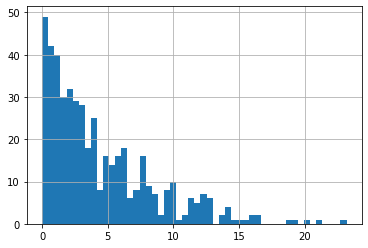

In [10]:
#calculate duration of stops, filter for minimum 3 second-stops
aggr = spvec_stops.groupby('stop_id').max('timestamp')
aggr['max_t'] = spvec_stops.groupby('stop_id')['timestamp'].max()
aggr['min_t'] = spvec_stops.groupby('stop_id')['timestamp'].min()
aggr['span_per_stop'] = (aggr['max_t']-aggr['min_t'])/np.timedelta64(1, 's')
aggr['type'] = spvec_stops.groupby('stop_id')['type'].apply(lambda x: list(np.unique(x))[0])
aggr['span_per_stop'].hist(bins=50)
aggr = aggr[aggr.span_per_stop>3]
print(len(aggr))
aggr.sort_values(by='min_t').head(20)

,exp_id,polygon,DOW,times,v_Taxi_MS,k_Taxi_MS,q_Taxi_MS,v_Car0050_MS,k_Car0050_MS,q_Car0050_MS,...,diff_2_all_MS,diff_3_all_MS,threshold,diff_to_threshold_quantile,density_induced,q_all_MS_s,k_all_MS_s,q_all_LD_s,k_all_LD_s,v2
0,1.0,polygon_r0,Wed,2018-10-24 08:31:00,36.983537,0.264116,0.237325,NaN,0.000000,0.000000,...,NaN,NaN,22.218664,21.286990,False,3188.985810,73.300493,2852.251651,40.005692,71.296145
1,1.0,polygon_r0,Wed,2018-10-24 08:31:30,42.355535,0.228994,0.231070,45.449044,0.163176,0.180186,...,NaN,NaN,22.218664,22.987365,False,3148.488968,69.779967,4685.841997,57.685940,81.230227
2,1.0,polygon_r0,Wed,2018-10-24 08:32:00,28.237023,0.152663,0.154047,22.724522,0.081588,0.090093,...,-2.799294,NaN,22.218664,18.487695,False,2185.071911,49.234811,3599.269940,44.575028,80.746331


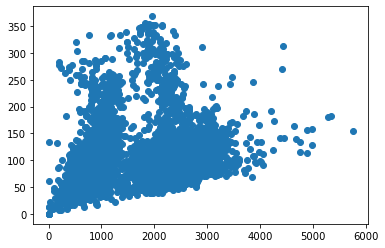

In [12]:
# load q,k,v data per interval (30 secs on rolling 3 minutes)
# add scaled up flows and densities

intervals_MS = pd.read_pickle('../output/data_processed/processed_data_all_bypolygon_speed_diff.pkl')
scalefactorsfile = '../output/data_processed/scalefactors_bypolygon.pkl' # 'scalefactors_bypolygon_bymode.pkl'    
# to read
with open(scalefactorsfile, 'rb') as f:
    scalefactors = pickle.load(f)
# test - scale values back up
cs = ['q_all_MS','k_all_MS','q_all_LD','k_all_LD']
#intervals_MS['q_all_LD'] = intervals_MS.q_all
#intervals_MS['k_all_LD'] = intervals_MS.k_all
for c in ['q_all_MS','k_all_MS','q_all_LD','k_all_LD']:
    scaledup = scaleup(intervals_MS[c],intervals_MS['polygon'],scalefactors,c)
    intervals_MS['%s_s'%c] = scaledup
    cs.append('%s_s'%c)
intervals_MS['v2'] = intervals_MS.q_all_LD_s / intervals_MS.k_all_LD_s
plt.scatter(intervals_MS.q_all_MS_s, intervals_MS.k_all_MS_s )
intervals_MS.head(3)

In [13]:
start = time.time()
intervals_MS = intervals_MS[intervals_MS.polygon == 'polygon_r0']
intervals_MS['stop_count'] = np.zeros(len(intervals_MS))
intervals_MS['stop_type'] = ['']*len(intervals_MS)
intervals_MS['stop_length'] = ['']*len(intervals_MS)
stop_types = []
# add a columns that matches the stop, vehicles type and duration to the intervals
for i,row in aggr.iterrows():
    t_start_higher_tmin = row['min_t'] < (intervals_MS.times-pd.Timedelta('150s')) #1
    t_start_lower_tmax = row['max_t'] > (intervals_MS.times - pd.Timedelta('150s')) #2
    t_start_lower_tmin = row['min_t'] > (intervals_MS.times-pd.Timedelta('150s')) #3
    t_end_higher_tmin = row['min_t'] < (intervals_MS.times+pd.Timedelta('30s')) #4
    #1+2 oder 3+4
    true = (t_start_higher_tmin & t_start_lower_tmax) | (t_start_lower_tmin & t_end_higher_tmin)
    # additionally add the vehicle type of that stop and the duration
    intervals_MS.stop_count += true
    intervals_MS['new_type'] = np.where(true, row.type, '')
    intervals_MS.stop_type= intervals_MS[['stop_type','new_type']].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
    intervals_MS['new_length'] = np.where(true, row.span_per_stop, '')
    intervals_MS.stop_length= intervals_MS[['new_length','stop_length']].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
intervals_MS['veh_stop_types'] = intervals_MS.stop_type.str.split(',').apply(lambda x: list(filter(lambda num: num != '', x)))
intervals_MS['veh_stop_lengths'] = intervals_MS.stop_length.str.split(',').apply(lambda x: list(filter(lambda num: num != '', x)))
intervals_MS.veh_stop_lengths = intervals_MS.veh_stop_lengths.apply(lambda x: list(map(float,x)))
intervals_MS = intervals_MS.drop(['stop_type','new_type','splitted','interm_splitted','stop_length','new_length'], axis=1)
print('Dauer: ', (time.time()-start))

KeyError: "['splitted', 'interm_splitted'] not found in axis"

## Count lane changes

In [ ]:
#idea: check when the vehicles cross the middle line (dashed line)


# Code to copy if necessary

### 4. Check some mode and speed related stuff

### Look at modal split on diff. links

,polygon,name,p0_lat_frontleft,p0_lon_frontleft,p0_lat_frontright,p0_lon_frontright,p0_lat_backright,p0_lon_backright,p0_lat_backleft,p0_lon_backleft,length,lanes,direction,busstops,seplane,comment,complexity,road_rank
0,0,polygon_r0,37.991314,23.734210,37.991427,23.734227,37.991224,23.735388,37.991136,23.735368,0.1050,3,170,0,1,2 + cab/bus/motorcycle lane,1,0
1,1,polygon_r1,37.987662,23.730315,37.987685,23.730157,37.988612,23.730365,37.988585,23.730539,0.1050,3,255,2,0,,1,0
2,2,polygon_r2,37.988508,23.728905,37.988441,23.729000,37.987979,23.728257,37.988080,23.728166,0.0840,2,35,0,0,,1,0
3,3,polygon_r3,37.980203,23.731516,37.980145,23.731402,37.980831,23.730832,37.980877,23.730955,0.0900,3,310,0,1,2 + cab/bus/motorcycle lane,1,0
4,4,polygon_r4,37.983096,23.730470,37.983160,23.730631,37.979420,23.733781,37.979350,23.733642,0.4990,4,130,0,0,"has traffic lights, one lane in opposite direc...",2,0
5,5,polygon_r5,37.991469,23.733146,37.991589,23.733177,37.991461,23.734021,37.991337,23.733988,0.0750,3,170,0,1,two lanes + bus/motorcycle lane (at peak times...,1,0
6,6,polygon_r6,37.990089,23.730882,37.990107,23.730730,37.991268,23.731006,37.991238,23.731186,0.1305,3,260,0,1,two lanes + bus/motorcycle lane (at peak times...,1,0
7,7,polygon_r7,37.987253,23.726909,37.987339,23.726821,37.987843,23.727636,37.987771,23.727769,0.0950,2,220,0,0,,1,0
8,8,polygon_r8,37.982050,23.730014,37.981978,23.729825,37.982568,23.729328,37.982645,23.729507,0.0790,3,310,1,0,,1,0
9,9,polygon_r9,37.990054,23.730700,37.989937,23.730659,37.990110,23.729593,37.990201,23.729613,0.0930,2,350,1,0,trees affect drone footage,1,1


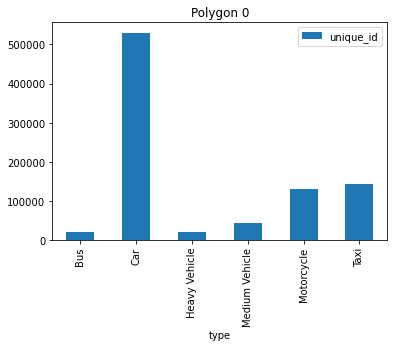

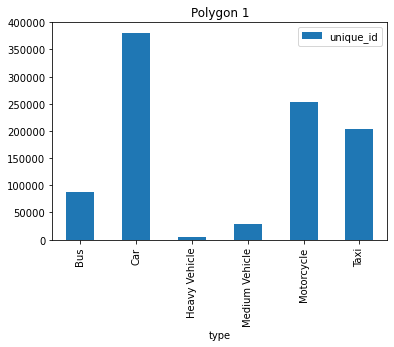

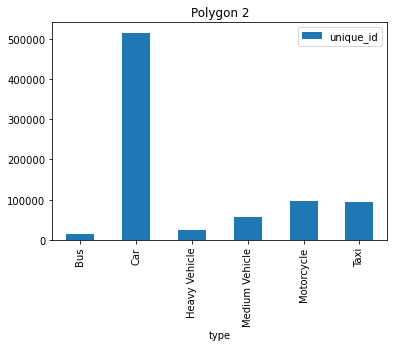

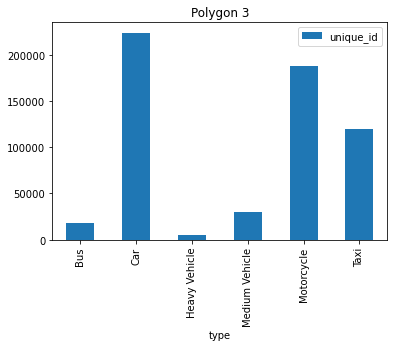

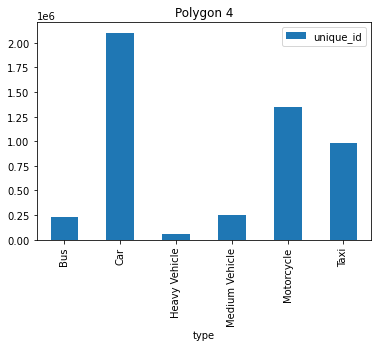

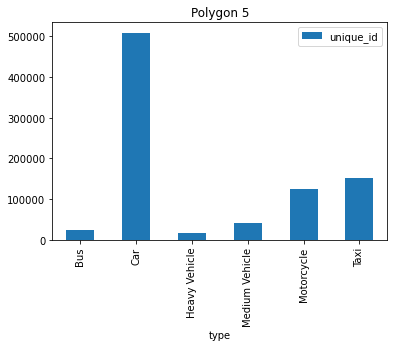

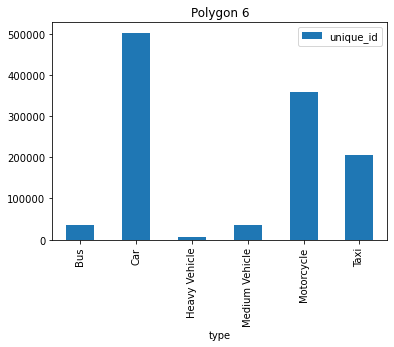

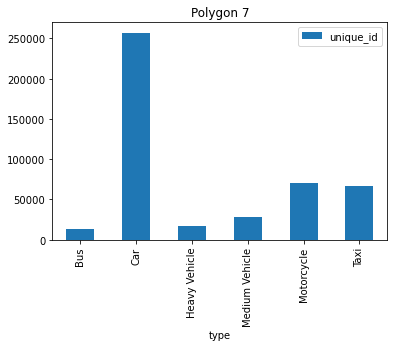

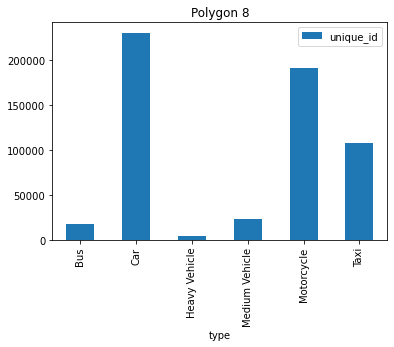

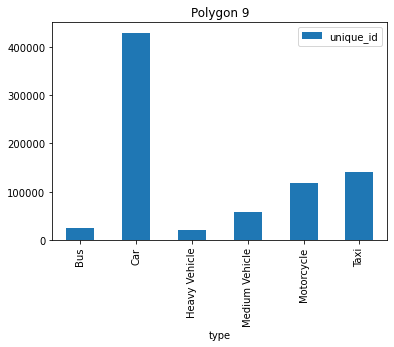

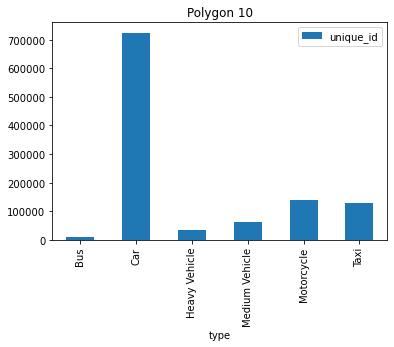

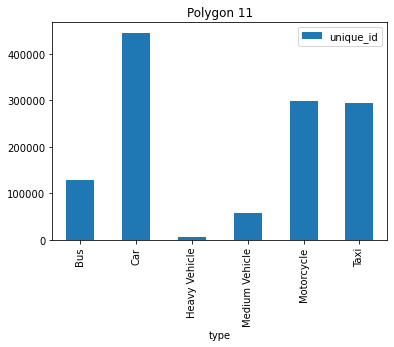

In [28]:
#########################
# CHECK IF ALL SEGMENTS HAVE ALL MODES
#########################

polygons = pd.read_csv('../data/polygons11.csv')
display(polygons)
for n in range(len(polygons)):
    
    #########################
    # choose polygon
    #########################

    POLYGON = polygons[polygons.polygon==n].iloc[0,:].to_dict()
    ps = ['p0_lon_frontleft','p0_lat_frontleft','p0_lon_frontright','p0_lat_frontright',
         'p0_lon_backright','p0_lat_backright','p0_lon_backleft','p0_lat_backleft']
    POLYGON['coords'] = Polygon([[POLYGON[ps[0]],POLYGON[ps[1]]],[POLYGON[ps[2]],POLYGON[ps[3]]],
                                 [POLYGON[ps[4]],POLYGON[ps[5]]],[POLYGON[ps[6]],POLYGON[ps[7]]]])
    [POLYGON.pop(k) for k in ps]
    
    #########################
    # import data
    #########################

    polygon_name = POLYGON['name']
    file_name = '../output/data_clean/prepared_data_%s.pkl'%(polygon_name)
    file_type = 'pickle' # 'csv'
    waypoints_w_dist_mode = import_clean_data(file_name,file_type,polygon_name)
    
    #########################
    # check data
    #########################

    tmp = waypoints_w_dist_mode[['type','unique_id']].groupby(by='type').count()
    tmp['type'] = tmp.index
    tmp.plot.bar(x='type',y='unique_id')
    plt.title('Polygon %i'%(n))
    plt.show()

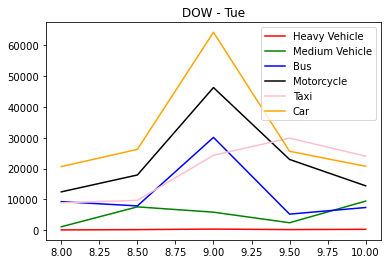

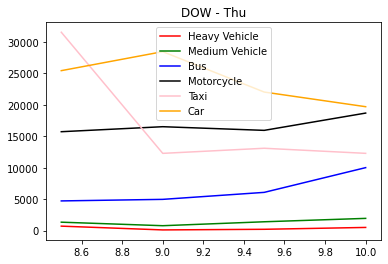

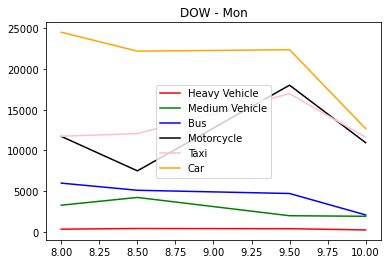

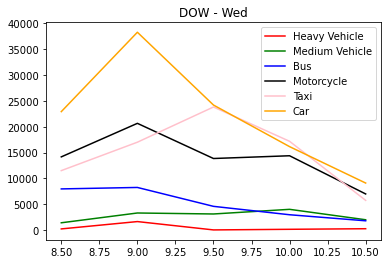

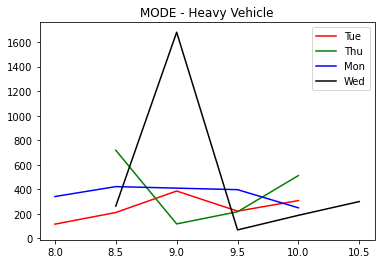

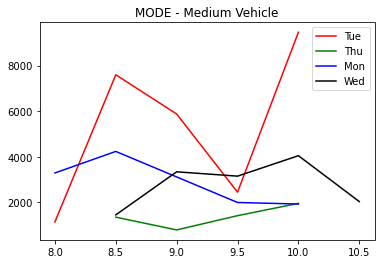

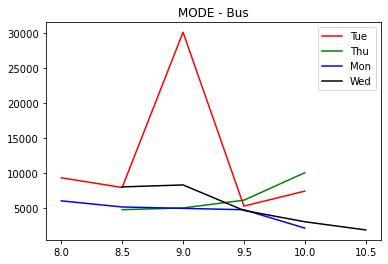

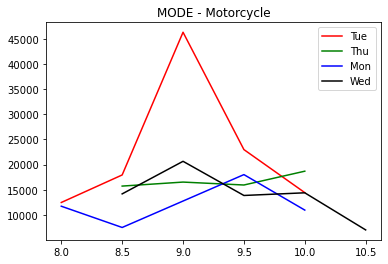

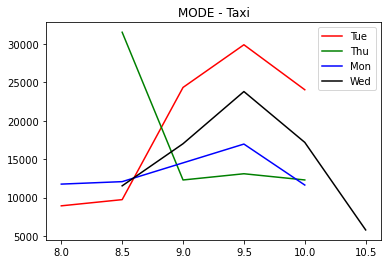

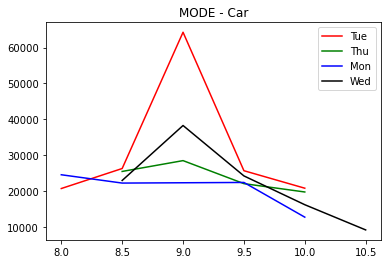

In [29]:
# compare mode % at diff time across weekdays
data = waypoints_w_dist_mode.groupby(['type','DOW','ST'])['time'].count().reset_index() 

##################
# check occurences for diff DOWs / modes / STs
##################

types = set(data.type)
DOWs = set(data.DOW)
coldict_types = dict(zip(types,['red','green','blue','black','pink','orange','purple','lightblue']))
coldict_DOWs = dict(zip(DOWs,['red','green','blue','black']))

# split by DOW
for day in DOWs:
    plt.figure(figsize=(6,4))
    subset = data[(data.DOW==day)]
    for m in types:
        plt.plot(subset[subset.type==m].ST,subset[subset.type==m].time,color=coldict_types[m],label=m)    
    plt.legend()
    plt.title('DOW - %s'%(day))
    plt.show()
    
# split by mode
for m in types:
    plt.figure(figsize=(6,4))
    subset = data[(data.type==m)]
    for day in DOWs:
        plt.plot(subset[subset.DOW==day].ST,subset[subset.DOW==day].time,color=coldict_DOWs[day],label=day)    
    plt.legend()
    plt.title('MODE - %s'%(m))
    plt.show()

### Look at exact trajectories of the different modes

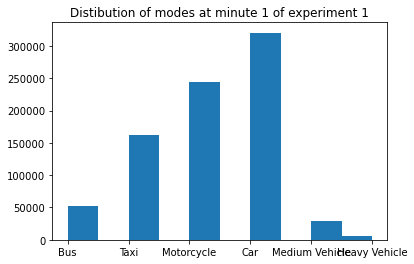

{'Heavy Vehicle', 'Medium Vehicle', 'Bus', 'Motorcycle', 'Taxi', 'Car'}


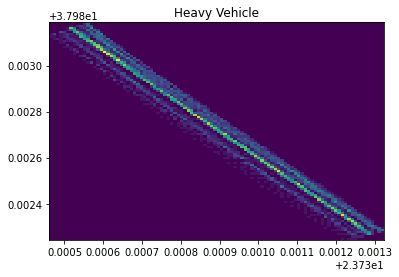

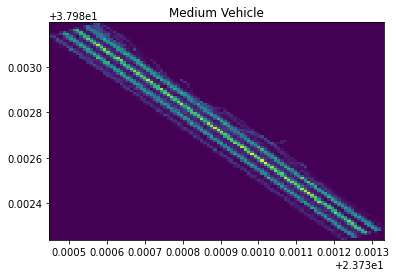

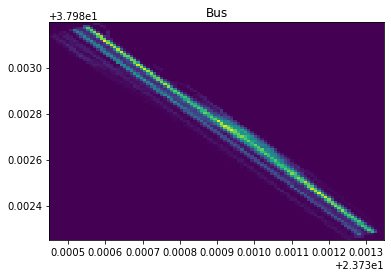

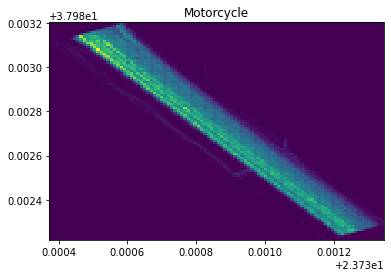

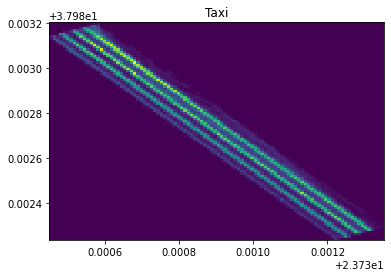

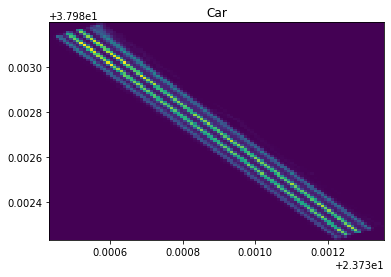

In [30]:
# select subset of data
data = waypoints_w_dist_mode[(waypoints_w_dist_mode.speed>3)]

# check distribution of modes
plt.hist(data['type'])
plt.title('Distibution of modes at minute 1 of experiment 1')
plt.show()

# check 2D histogram by mode 
print(set(data['type']))
for subset in set(data['type']):
    subset_data = data[data['type']==subset]
    _ = plt.hist2d(subset_data.geometry.x,subset_data.geometry.y,bins=100) # h, xedges, yedges, image = 
    plt.title('%s'%(subset))
    plt.show()

### Check speed and distance values

In [31]:
def lat_lon_2_m(latitude_1, longitude_1, latitude_2, longitude_2):
    
    radius_earth = 6371009 # Radius of the earth in m
    d_latitude = np.deg2rad(latitude_2 - latitude_1)
    d_longitude = np.deg2rad(longitude_2 - longitude_1)
    latitude_1 = np.deg2rad(latitude_1)
    latitude_2 = np.deg2rad(latitude_2)
    
    a = (np.sin(d_latitude / 2)) ** 2 + np.cos(latitude_1) * np.cos(latitude_2) * (np.sin(d_longitude / 2)) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = radius_earth * c
    
    return distance

def calculate_distance(latitude, longitude):
    distance = np.zeros(len(latitude))
    for i in range(0, len(latitude) - 1):
        # calc distance between two consecutive points using lat_lon_2_m function
        distance[i + 1] = lat_lon_2_m(latitude[i],longitude[i],latitude[i + 1],longitude[i + 1])
    return distance

def calculate_speed(array_distances,array_deltatime):
    speed = [0] * (len(array_distances)-1)
    for i in range(0, len(array_distances)-1):
        if array_deltatime[i] != 0:
            speed[i] = array_distances[i] / array_deltatime[i] * 3.6
        elif array_distances[i] == 0:
            speed[i] = 0
        else: 
            speed[i] = speed[i-1]
    # Add entry to acceleration, to have same length as speed
    speed = np.append(speed, [0])
    return speed

In [35]:
display(waypoints_w_dist_mode.head(3))

,unique_id,type,exp_id,DOW,ST,ET,DOY,track_id,time,speed,trv_dist,timestamp,geometry
597,1000650,Bus,1,Wed,8.5,9.0,2018-10-24,650,459.40,27.7997,183.360564,2018-10-24 08:37:39.400,POINT (23.73131 37.98228)
598,1000650,Bus,1,Wed,8.5,9.0,2018-10-24,650,459.56,27.9001,184.531063,2018-10-24 08:37:39.560,POINT (23.73130 37.98229)
599,1000650,Bus,1,Wed,8.5,9.0,2018-10-24,650,459.72,27.9637,185.752482,2018-10-24 08:37:39.720,POINT (23.73130 37.98230)


In [45]:
testdata = waypoints_w_dist_mode[(waypoints_w_dist_mode.exp_id==1)&(waypoints_w_dist_mode.track_id==650)].reset_index()
testdata.geometry.y

0     37.982282
1     37.982291
2     37.982300
3     37.982309
4     37.982319
        ...    
89    37.983131
90    37.983141
91    37.983151
92    37.983161
93    37.983171
Length: 94, dtype: float64

      speed  speed_latlon  speed_trv_dist
89  29.7559     29.577347       29.528950
90  29.7808     29.577346       29.529218
91  29.8457     29.577345       29.529484
92  29.9492     29.577344       29.529745
93  30.0853      0.000000        0.000000


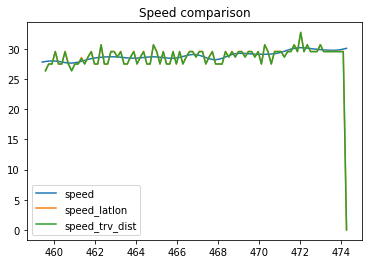

   delta_dist  delta_dist_latlon
0         NaN           0.000000
1    1.170499           1.173842
2    1.221419           1.221936
3    1.221419           1.221936
4    1.311902           1.314553


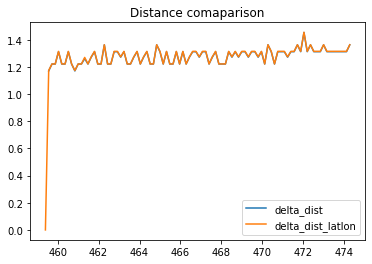

In [46]:
# small subset of data for testing
testdata = waypoints_w_dist_mode[(waypoints_w_dist_mode.exp_id==1)&(waypoints_w_dist_mode.track_id==650)].reset_index()

# calc dist using lat and lon
testdata['delta_dist_latlon'] = calculate_distance(testdata.geometry.y,testdata.geometry.x)#testdata.lat,testdata.lon
testdata['trv_dist_latlon'] = testdata.delta_dist_latlon.cumsum()

# calc deltatime & deltadist
testdata['deltatime'] = testdata.time.diff()
testdata['delta_dist'] = testdata.trv_dist.diff()

# calc speed using lat and lon
testdata['speed_latlon'] = calculate_speed(testdata.delta_dist_latlon,testdata.deltatime)
testdata['speed_trv_dist'] = calculate_speed(testdata.delta_dist,testdata.deltatime)

# check speed plot
print(testdata[['speed','speed_latlon','speed_trv_dist']].tail())
plt.plot(testdata.time,testdata.speed,label='speed')
plt.plot(testdata.time,testdata.speed_latlon,label='speed_latlon')
plt.plot(testdata.time,testdata.speed_trv_dist,label='speed_trv_dist')
plt.legend()
plt.title('Speed comparison')
plt.show()

# check dist plot
print(testdata[['delta_dist','delta_dist_latlon']].head())
plt.plot(testdata.time,testdata.delta_dist,label='delta_dist')
plt.plot(testdata.time,testdata.delta_dist_latlon,label='delta_dist_latlon')
plt.legend()
plt.title('Distance comaparison')
plt.show()

### --> given speed pretty much the same as lat lon speed 

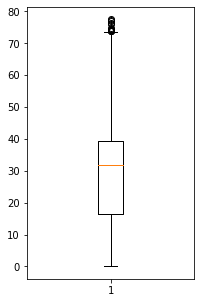

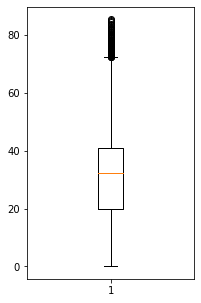

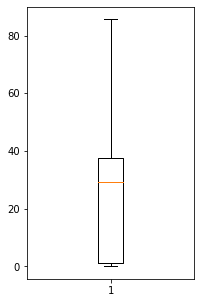

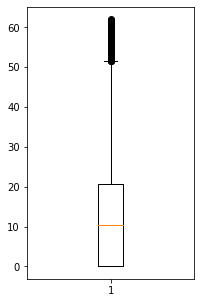

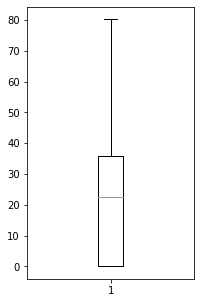

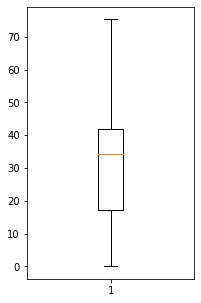

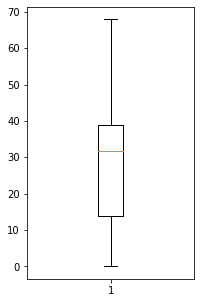

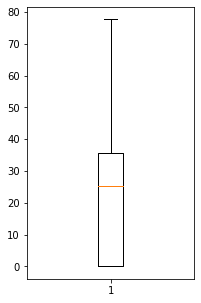

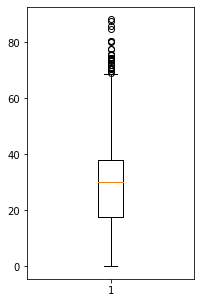

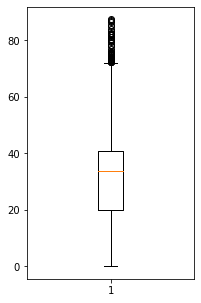

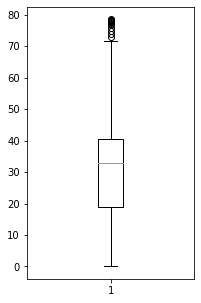

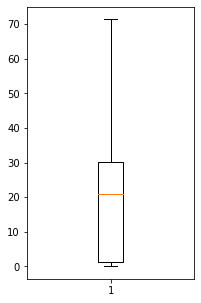

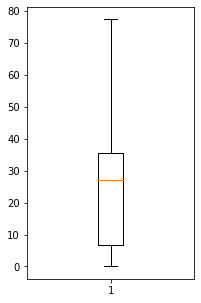

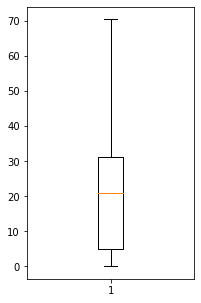

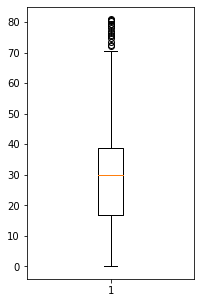

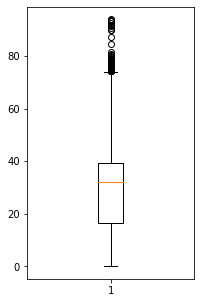

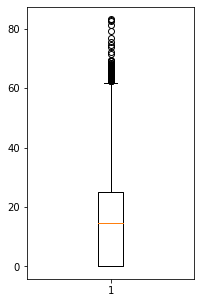

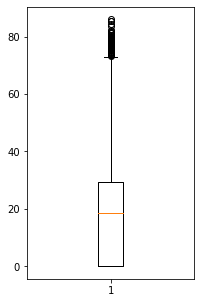

In [40]:
##Unnecessary tryouts

for exp in waypoints_w_dist_mode.exp_id.unique():
    subset = waypoints_w_dist_mode[(waypoints_w_dist_mode.exp_id==exp)]
    plt.figure(figsize=(3,5))
    plt.boxplot(subset.speed)
    #for unid in subset.groupby('unique_id'):
        #plt.plot(unid[1].time, unid[1].speed)
        #plt.boxplot(unid[1].speed)
    
    #plt.plot(subset.time, subset.speed,'.')